Boosting (originally called *hypothesis boosting*) refers to any ensemble method that can combine several *weak learners* into a *strong learner*. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

<h3>Data</h3>

In [2]:
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

In [3]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>Adaptive Boosting (AdaBoost)</h3>

Let's train an AdaBoost classifier based on 30 *decision stumps*.
- A decision stump is a decision tree with `max_depth` = 1 (i.e., a decision tree composed of a single decision node plus two leaf nodes).

In [5]:
def ada_boost(X_train, X_test, y_train, y_test, algo):
    ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=30,
                                 random_state=42,
                                 algorithm=algo)
    ada_clf.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_true=y_train, y_pred=ada_clf.predict(X_train))
    test_accuracy = accuracy_score(y_true=y_test, y_pred=ada_clf.predict(X_test))
    print(f'Training accuracy: {train_accuracy:.3f}')
    print(f'Test accuracy: {test_accuracy:.3f}')

In [6]:
ada_boost(X_train, X_test, y_train, y_test, algo='SAMME')

Training accuracy: 0.983
Test accuracy: 0.967


In [7]:
ada_boost(X_train, X_test, y_train, y_test, algo='SAMME.R')

Training accuracy: 0.967
Test accuracy: 1.000


/Users/herrakaava/anaconda3/envs/geron/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<h3>Gradient Boosting</h3>

Gradient boosting works by sequentially adding predictors (models) to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, gradient boosting tries to fit the new predictor to the *residual errors* made by the previous predictor.

In [2]:
##### Generate a noisy quadratic dataset #####

np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3 * X[:,0]**2 + 0.05 * np.random.randn(100)    # y = 3X^2 + Gaussian noise

In [3]:
##### Gradient boosting by hand #####

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)     # Residual errors

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)
y3 = y2 - tree_reg2.predict(X)    # Residual errors

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we have an ensemble containing 3 trees. It can make predictions on a new instance simply by adding up the predictions of all the 3 trees:

$$ \hat{f}_{\text{GB}}(\boldsymbol{x}_0) = \hat{f}_1(\boldsymbol{x}_0) \, + \, \hat{f}_2(\boldsymbol{x}_0) \, + \, \hat{f}_3(\boldsymbol{x}_0). $$

In [23]:
x0 = np.array([-0.4, 0, 0.5])[:, np.newaxis]
sum(tree.predict(x0) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

We can create the same ensemble has above much easier using sklearn:

In [25]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- The `learning_rate` is a hyperparameter that controls the regularization strength.
- If you set it to a low value (e.g., 0.05), you will need more trees in the ensemble to fit the training data well, but the predictions will usually generalize better.

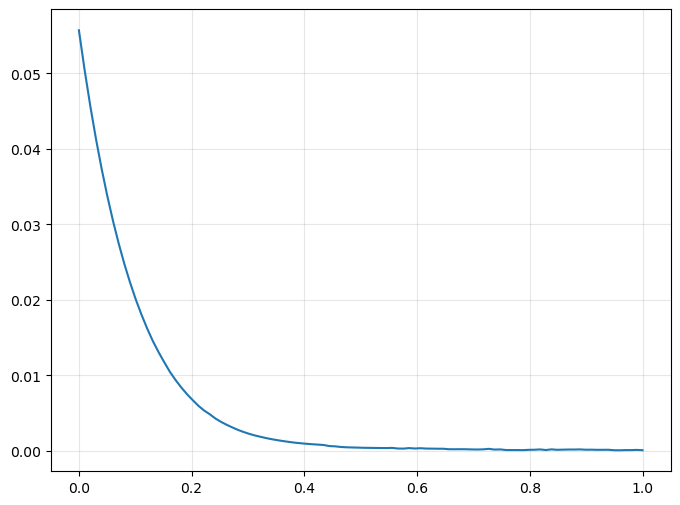

In [33]:
train_mse = []
learning_rates = np.linspace(0.0, 1.0, 100)
for lr in learning_rates:
    model = GradientBoostingRegressor(max_depth=5, n_estimators=5, learning_rate=lr, random_state=42)
    model.fit(X, y)
    train_mse.append(mean_squared_error(y_true=y, y_pred=model.predict(X)))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(learning_rates, train_mse, zorder=2)
ax.grid(True, alpha=0.3, zorder=1);

To find the optimal number of trees (`n_estimators`) we can perform *early stopping* (with *patience*) via the `n_iter_no_change` hyperparameter. If we set it equal to 10 for example, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn't help.

In [39]:
gbrt_best = GradientBoostingRegressor(loss='squared_error',
                                      max_depth=2, 
                                      learning_rate=0.05, 
                                      n_estimators=500,
                                      n_iter_no_change=10,
                                      random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [40]:
gbrt_best.n_estimators_

92

- After 92 trees, there was no improvement in the squared error (at least for 10 iterations), so more trees were not added after this.
- Note that when `n_iter_no_change` is set, the `fit()` method automatically splits the training set into a smaller training set and a validation set: this allows it to evaluate the model's performance each time it adds a new tree. The size of the validation set is controlled via the `validation_fraction` hyperparameter, which is 10% by default.
- The `tol` hyperparameter controls the tolerance for the early stopping. When the loss is not improving by at least by the amount that was set for tol for ``n_iter_no_change`` iterations (if set to a number), the training stops.

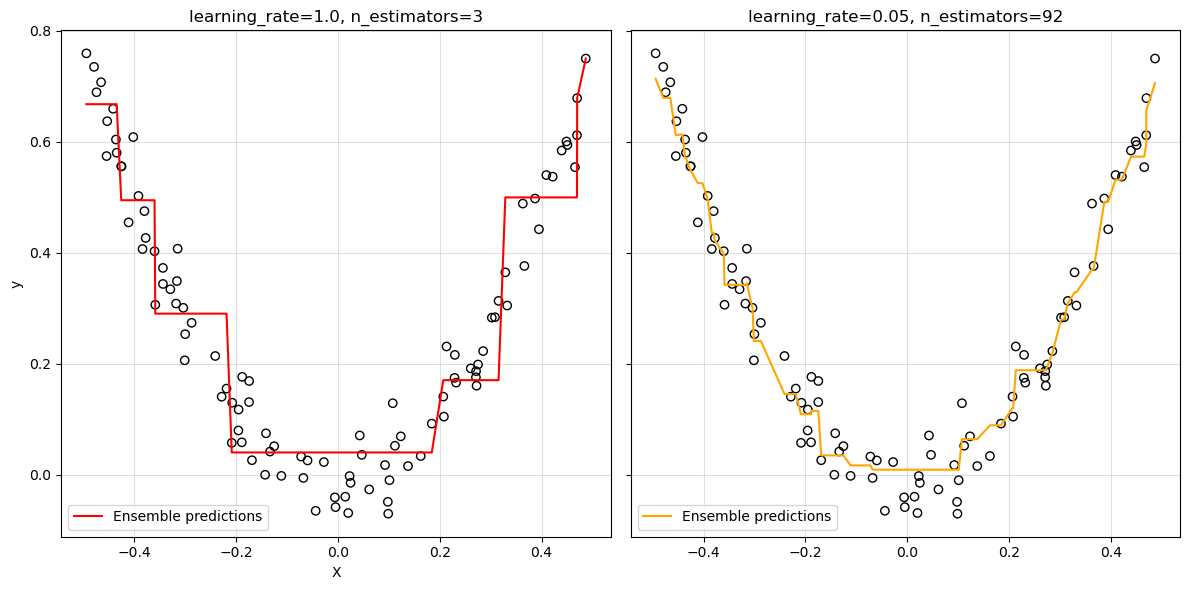

In [64]:
# Predict with the both models (n_estimators=3, n_estimators=92)
y_pred_est3 = gbrt.predict(X)
y_pred_est92 = gbrt_best.predict(X)

# Sort the predictions
y_pred_est3_sorted = y_pred_est3[np.argsort(X.ravel())]
y_pred_est92_sorted = y_pred_est92[np.argsort(X.ravel())]

# Sort the original X
X_sorted = np.sort(X.ravel())

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
ax[0].scatter(X, y, facecolors='none', edgecolors='black', zorder=2)
ax[0].plot(X_sorted, y_pred_est3_sorted, color='red', label='Ensemble predictions', zorder=3)
ax[0].grid(True, alpha=0.4, zorder=1)
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')
ax[0].set_title(f'learning_rate=1.0, n_estimators=3')
ax[0].legend()
ax[1].scatter(X, y, facecolors='none', edgecolors='black', zorder=2)
ax[1].plot(X_sorted, y_pred_est92_sorted, color='orange', label='Ensemble predictions', zorder=3)
ax[1].grid(True, alpha=0.4, zorder=1)
ax[1].set_title(f'learning_rate=0.05, n_estimators=92')
ax[1].legend()
plt.tight_layout();

In [67]:
print(mean_squared_error(y_true=y, y_pred=y_pred_est3).item())
print(mean_squared_error(y_true=y, y_pred=y_pred_est92).item())

0.005038058938993283
0.0013384703469387304


- The error is 4 times smaller with the ensemble with 92 trees.

<h3>Histogram-Based Gradient Boosting</h3>